# 1) Simple Inference
In this notebook, we'll run through the most barebones version of inference with `pitchfork`.

We'll use the same priors as in the paper, and won't worry about tuning the hyperparameters of `UltraNest` or the surface term correlated noise model GP beyond their default (Solar) values.

This should work fine in many cases, and mean you can go from importing the stellar observable dictionary you made and saved in `0-make-star-dict.ipynb` to posterior samples in a couple minutes :)

In [1]:
import numpy as np
import json
import corner
import matplotlib.pyplot as plt

from scripts import pitchfork_compile, pitchfork_sampler, posterior_plot

## compile pitchfork
We'll start by compiling the `pitchfork` emulator which we'll pass to our sampler to use when evaluating the likelihood function.

We'll also need the full covariance matrix for `pitchfork` prediction residuals over the test set later on, so we'll import this now, too:

In [2]:
with open('pitchfork/pitchfork.json', 'r') as fp:
    pitchfork_dict = json.load(fp)

with open('pitchfork/pitchfork_info.json', 'r') as fp:
    pitchfork_info = json.load(fp)

pitchfork_cov = np.loadtxt('pitchfork/pitchfork_covariance.txt')

pitchfork = pitchfork_compile(pitchfork_dict, pitchfork_info)

I've shown how to compile and import `pitchfork` here so that it can be used independantly from the sampler within this notebook via `pitchfork.predict(inputs)` - we'll use this later on for a quick posterior predictive check on our results!

## initialise sampler
Now we've imported `pitchfork` we can initialise our sampler.

I've set this up so that the sampler can be initialised with the objects that aren't likely to change if we want to run inference on multiple stars in the same notebook (i.e. `pitchfork`, `pitchfork_cov`, and the prior).


In [3]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

Done! We initialise the parts of the sampler that will vary on a star-by-star basis, like the observational uncertainty contribution to the likelihood covariance matrix, later on.

## inspect prior
Now the sampler is initialised, we can check the default priors on the fundamental properties that we'll use for sampling if the user doesn't pass their own:

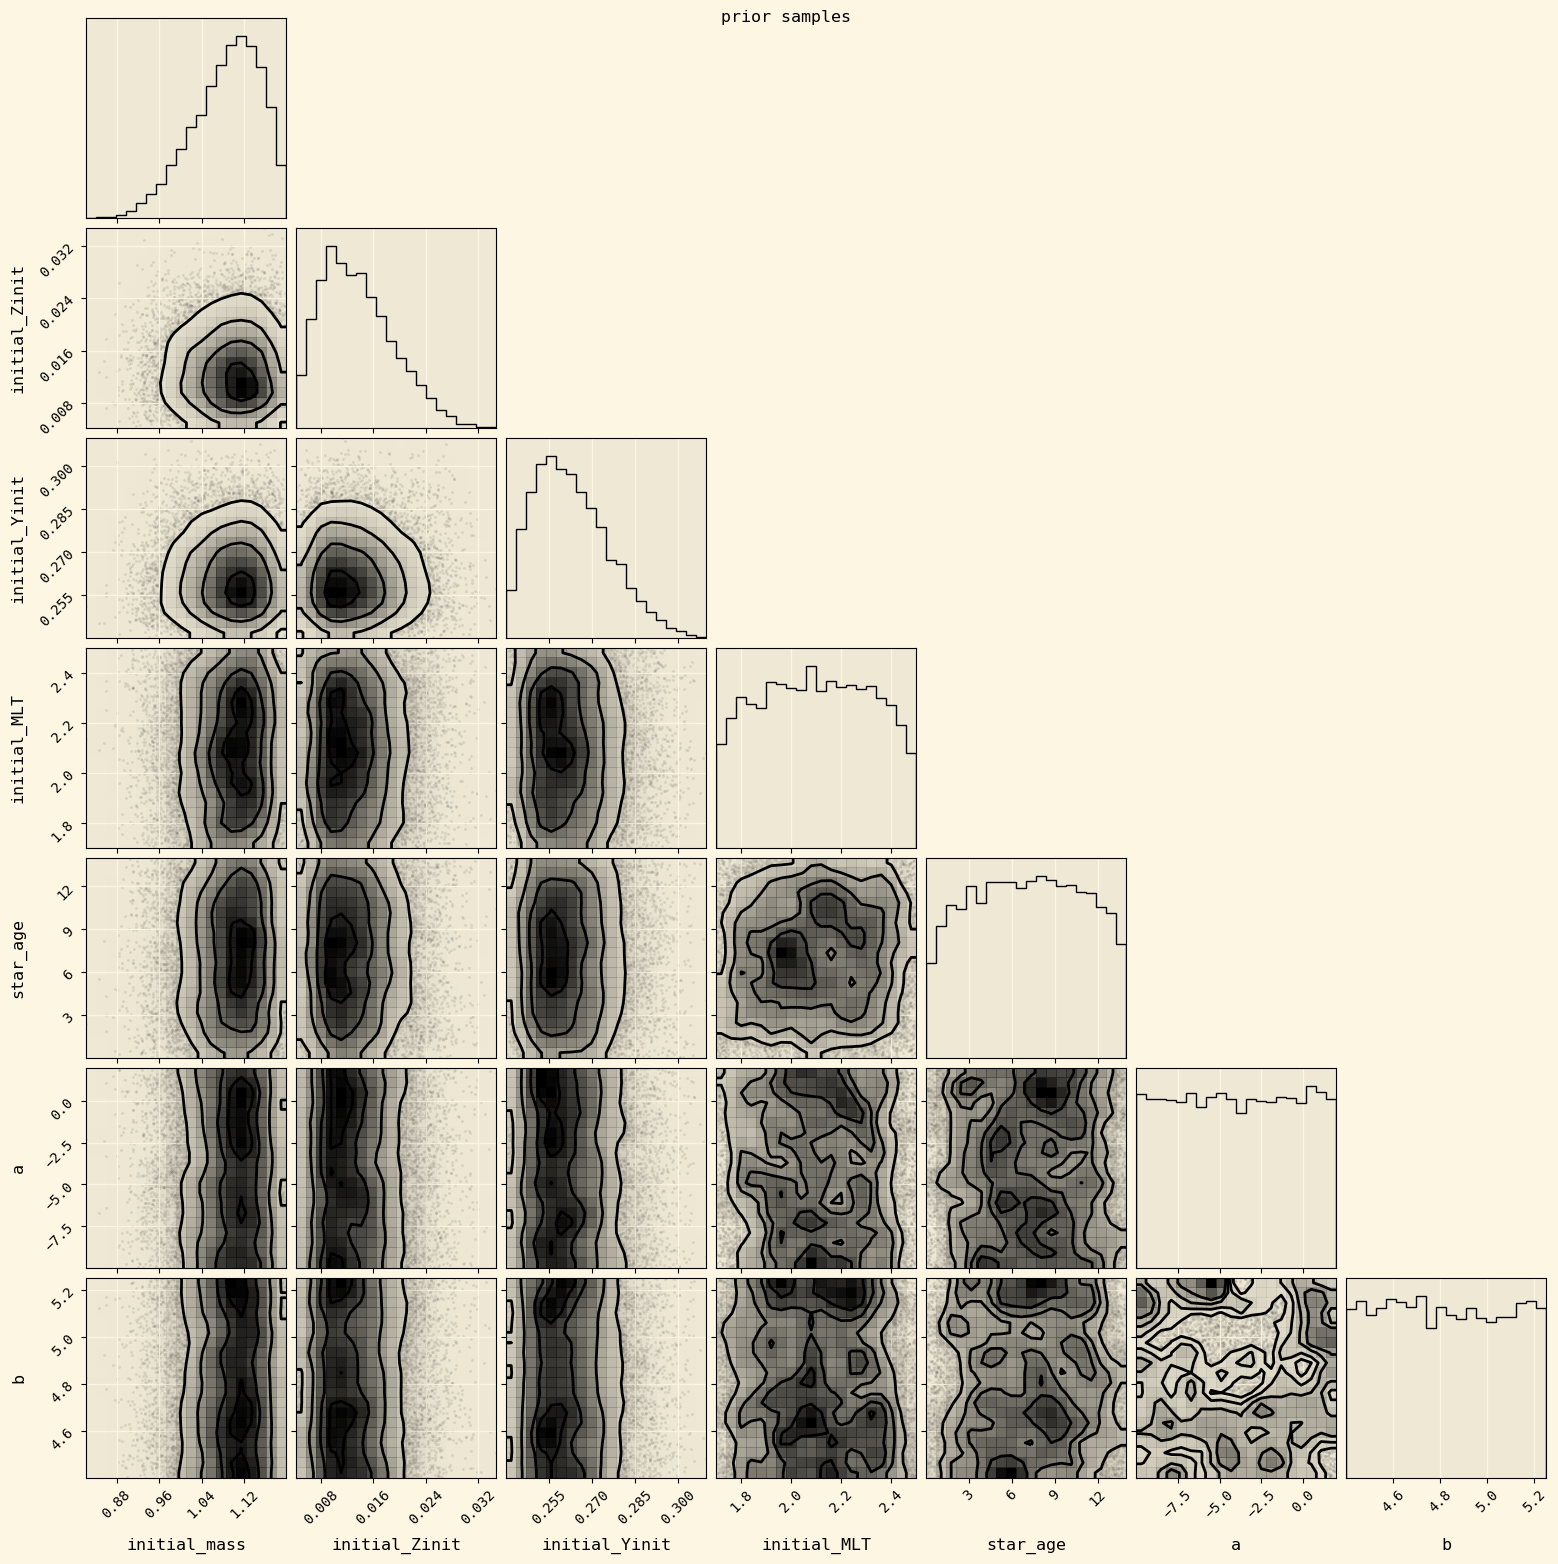

In [4]:
priors = sampler.priors

labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

size = 10000
prior_samples = np.array([prior.rvs(size=size) for prior in priors])

corner.corner(prior_samples.T, color='black', labels = labels, hist_kwargs={'density':True}, smooth=True);
plt.suptitle('prior samples')
plt.show()

## load in star
Now we'll run the initialised sampler on a specific star using the `star_name` keyword (to tell the sampler which folder in `/stars/...` to check for the stellar observables dict).

I'll show an example here for the Sun - get ready for rapid inference with `pitchfork` and some fun `UltraNest` live plots :)

In [5]:
star_name = 'Sun'

results = sampler(star_name)

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2  79 [-2.2696..-2.2695]*| it/evals=8265/185730 eff=4.4596% N=400        0      0  
[ultranest] Likelihood function evaluations: 185730
[ultranest]   logZ = -18.17 +- 0.1478
[ultranest] Effective samples strategy satisfied (ESS = 2431.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 1m 34.9s!


Nice! You've just sampled the posterior distributions of 5 stellar fundamental properties and 2 asteroseismic surface term parameters using individual radial modes of oscillation as constraints in (hopefully) very little time at all!

Let's check those posteriors...

## inspect posteriors
The results variable above is in the default dictionary format output by `UltraNest`. That means the posterior samples are stored in `results['samples']`.

You can access and plot these manually using corner (i.e. `corner.corner(results['samples'], ...)` but to make things easier I've included a function to do this for you in `scripts/utils.py` - `posterior_plot` :

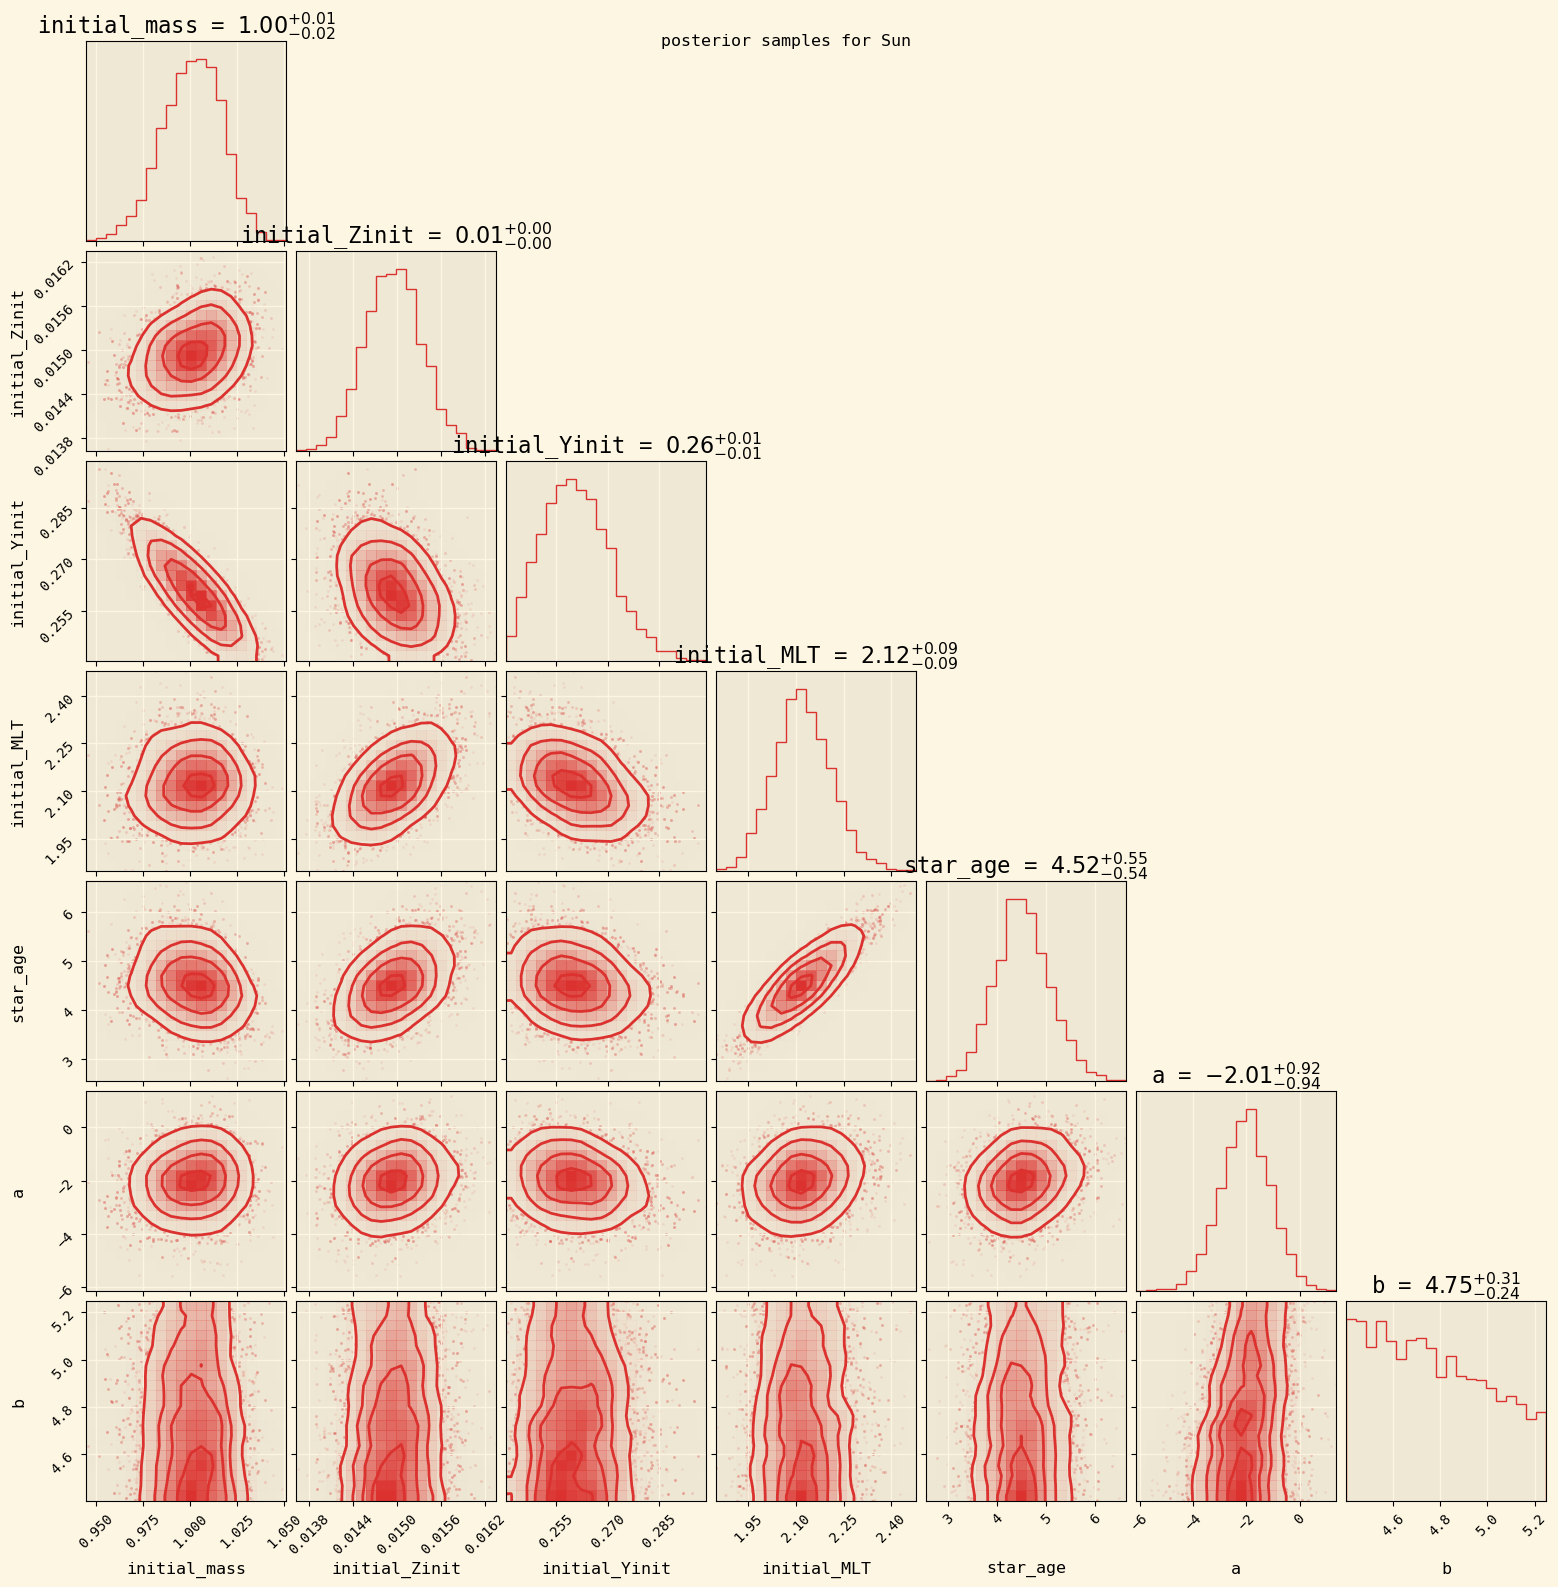

In [6]:
posterior_plot(results, star_name=star_name);

Nice! But it'd be nicer to contextualise these posteriors against the prior distribution used for this sampling run by overplotting the posterior over the prior.

If you've read the paper you'll know I like doing this, so I made this an option in `posterior_plot`:

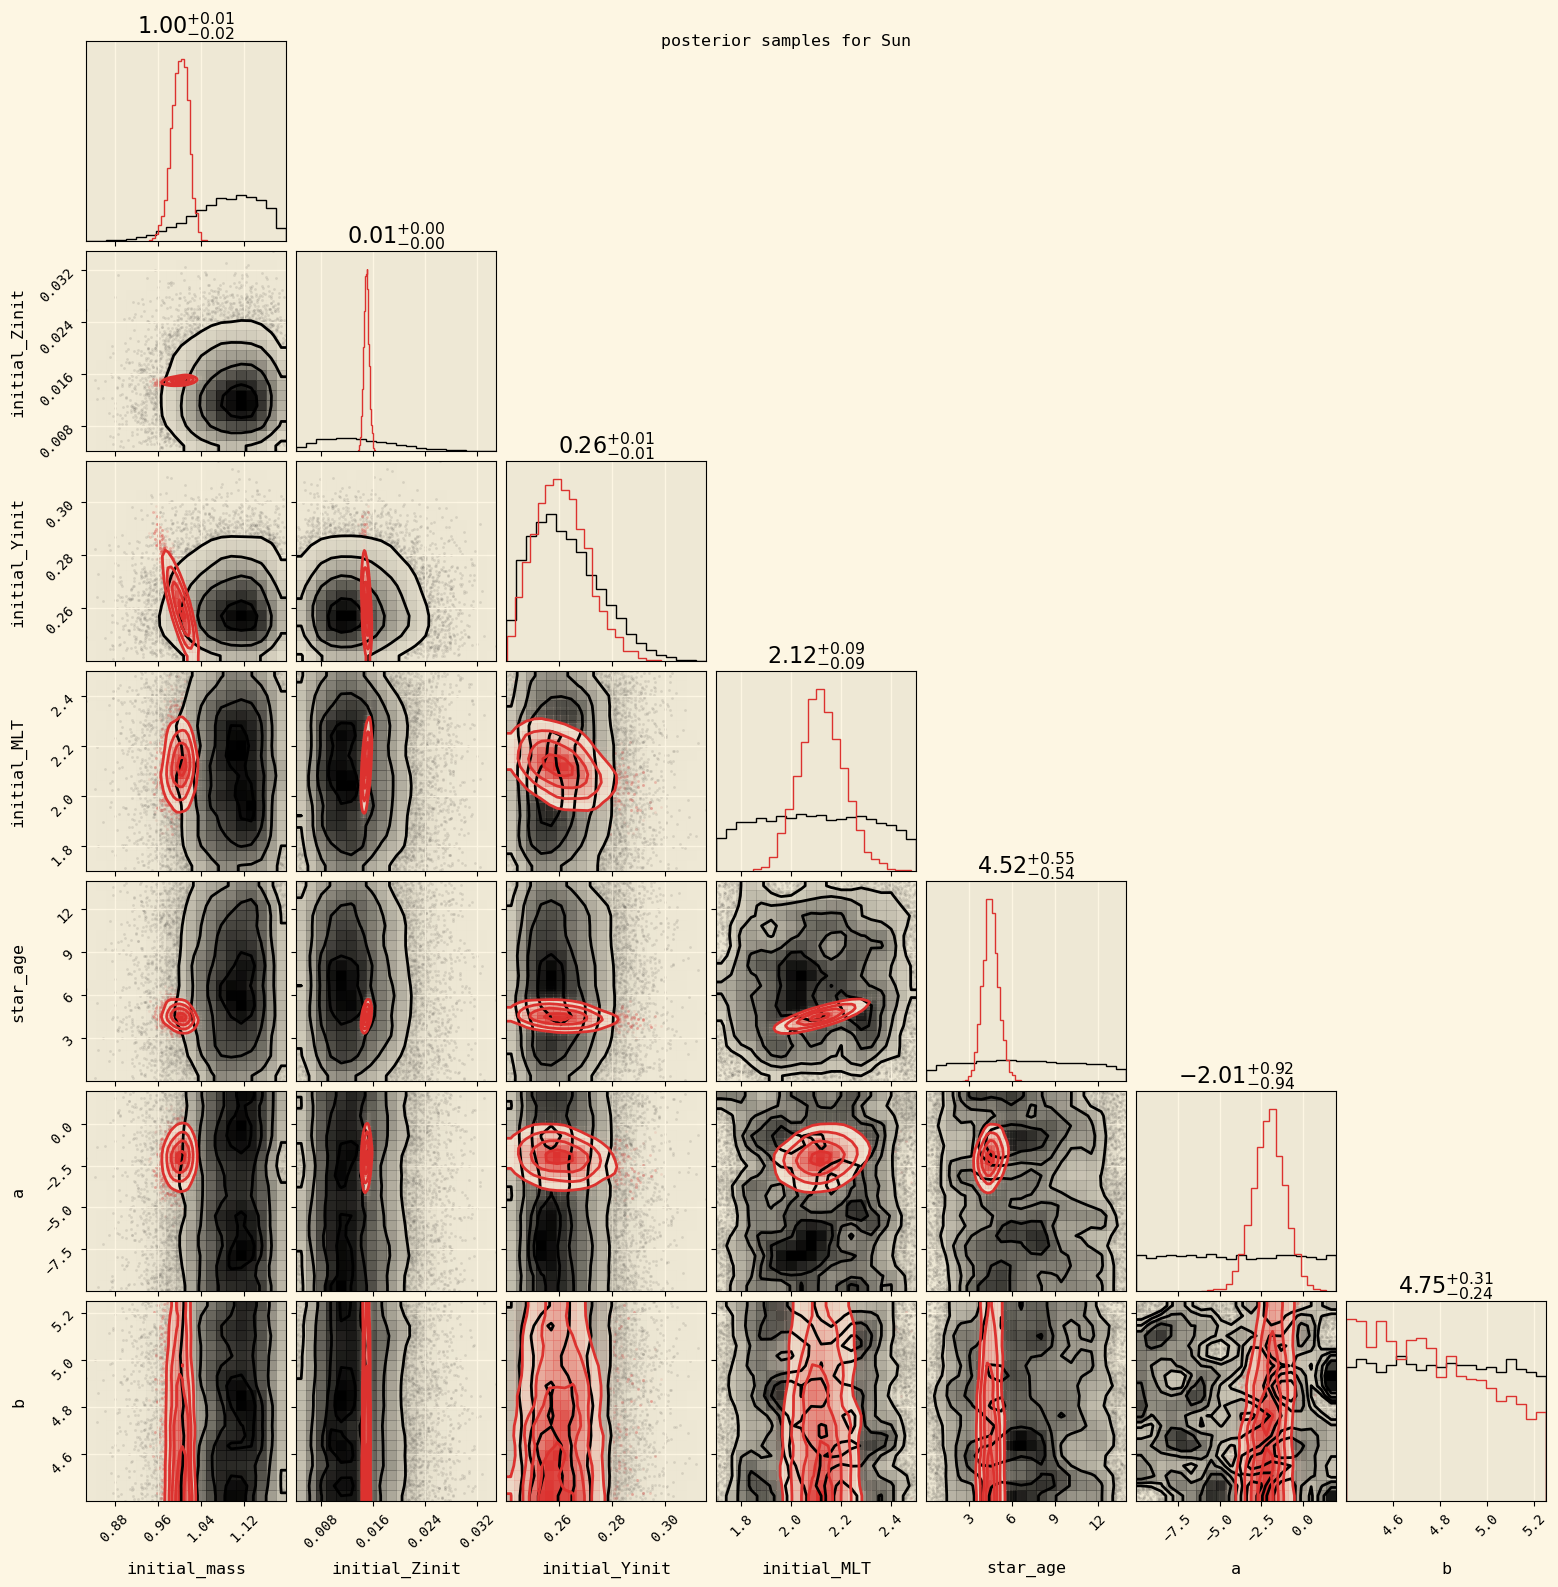

In [7]:
posterior_plot(results, include_prior=True, star_name=star_name);